In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sample_freq = 25.6 * 1000
cutoff_freq = 20000

In [3]:
root_dir = 'Learning_Set'
files_lst = os.listdir(root_dir)
files_lst

['Bearing1_1',
 'Bearing1_2',
 'Bearing2_1',
 'Bearing2_2',
 'Bearing3_1',
 'Bearing3_2']

In [4]:
def create_label(files_lst, sample_freq, cutoff_freq):

    labels = []
    for files in tqdm(files_lst):
        L = []
        df = pd.read_csv(files, sep=',', header=None)
        hsig = df.iloc[:, -2].values
        vsig = df.iloc[:, -1].values

        for signal in [hsig, vsig]:
            X = fft(signal)
            freqs = fftfreq(len(signal)) * sample_freq
            Xf =  np.abs(X[1:len(signal) // 2])
            freq = freqs[1:len(signal) // 2]
            Xf = uniform_filter1d(Xf, size=5)
            L.append(np.mean(Xf[freq < cutoff_freq]))
        
        labels.append(np.max(L))
    
    labels = (np.array(labels) - np.min(labels)) / (np.max(labels) - np.min(labels))

    return labels

Process Bearing1_1


100%|██████████| 2803/2803 [00:03<00:00, 854.79it/s]


Process Bearing1_2


100%|██████████| 871/871 [00:00<00:00, 871.67it/s]


Process Bearing2_1


100%|██████████| 911/911 [00:01<00:00, 881.28it/s]


Process Bearing2_2


100%|██████████| 797/797 [00:00<00:00, 880.91it/s]


Process Bearing3_1


100%|██████████| 515/515 [00:00<00:00, 851.40it/s]


Process Bearing3_2


100%|██████████| 1637/1637 [00:01<00:00, 883.63it/s]


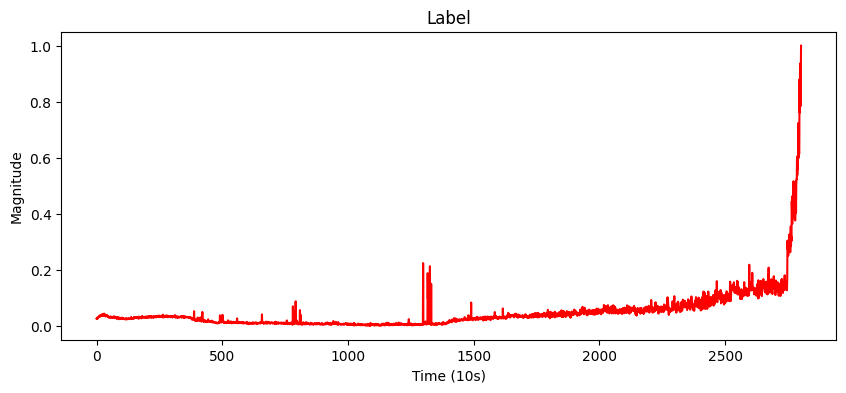

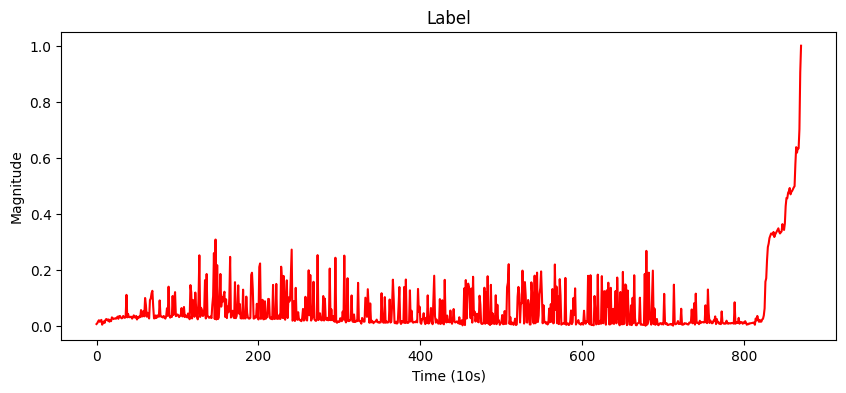

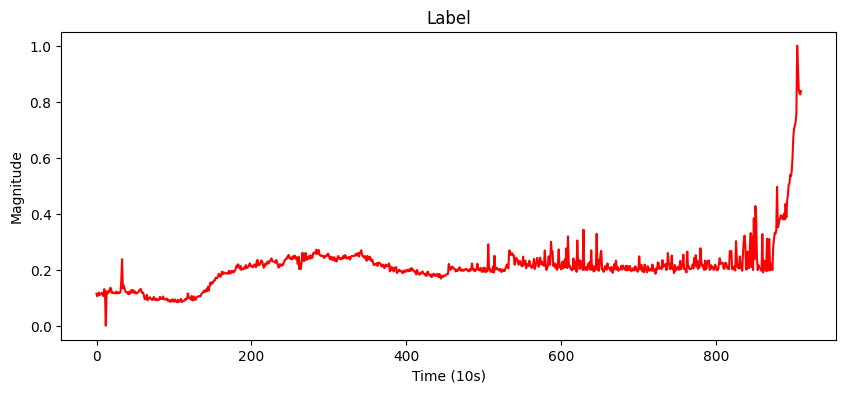

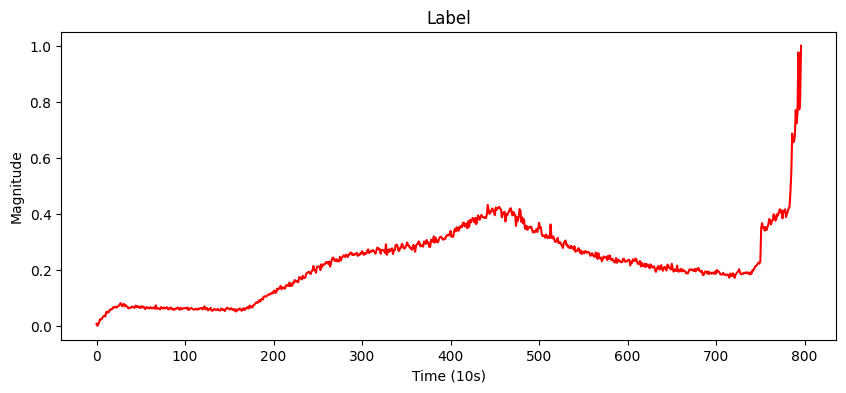

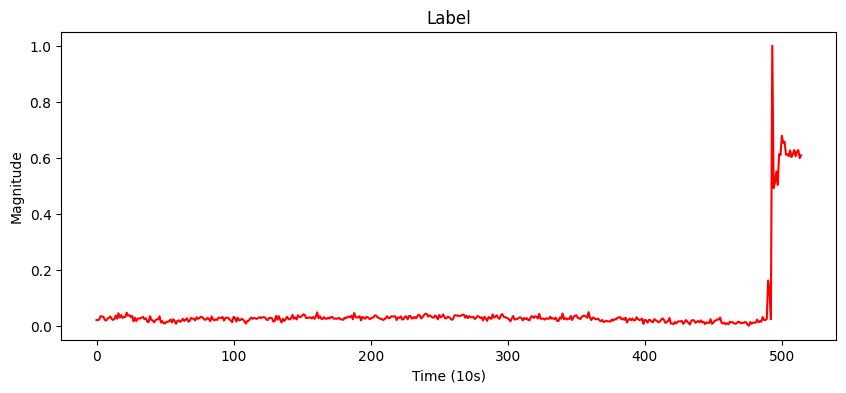

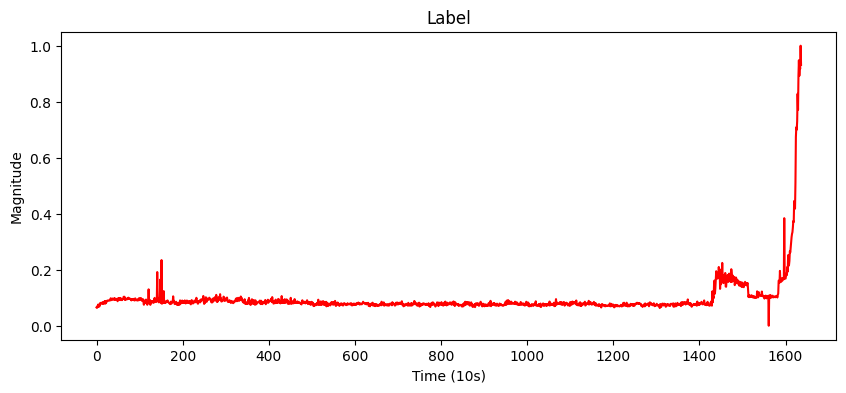

In [5]:
label = 'Label'
if not os.path.exists(label):
    os.makedirs(label)
for file_dir in files_lst:
    print(f'Process {file_dir}')
    file_lst = glob.glob(os.path.join(root_dir, file_dir, 'acc_*.csv'))
    labels = create_label(file_lst, sample_freq, cutoff_freq)
    plt.figure(figsize=(10, 4))
    plt.plot(labels, c='red')
    plt.title('Label')
    plt.xlabel('Time (10s)')
    plt.ylabel('Magnitude')
    np.save(os.path.join(label, '{}.npy'.format(file_dir)), labels)



In [2]:
class CNNDataset(Dataset):
    def __init__(self, data_root_dir, label_root_dir):
        super(CNNDataset, self).__init__()

        self.data_dir = data_root_dir
        self.label_dir = label_root_dir

        self.data = []
        self.label = []

        label_files = glob.glob(os.path.join(self.label_dir, '*.npy'))
        cycle_names = [os.path.basename(f).replace('.npy', '') for f in label_files]

        for cycle_name, label_file in zip(cycle_names, label_files):
            signal_files = glob.glob(os.path.join(self.data_dir, cycle_name, 'acc_*.csv'))
            signal_label = np.load(label_file)

            self.data.extend(signal_files)
            self.label.extend(signal_label.tolist())
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_name = self.data[index]
        label_name = self.label[index]

        df = pd.read_csv(file_name, sep=',', header=None)
        signal = df.iloc[:, -2:].values
        data = np.transpose(signal, (1, 0))
        
        data = torch.from_numpy(data).type(torch.float32)
        label = torch.from_numpy(np.asarray(label_name))

        return data, label


    

In [39]:
dataset = CNNDataset('Learning_set', 'Label')
len(dataset)

7534

In [6]:
# Define Model
class CNN(nn.Module):
    def __init__(self, data_shape, in_channel, out_channel):
        super(CNN, self).__init__()

        self.data_shape = data_shape
        self.conv1 = nn.Conv1d(in_channel, out_channel, kernel_size=4, stride=2)
        self.map1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(out_channel, out_channel, kernel_size=2)
        self.map2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.get_linear_size()

        self.fc1 = nn.Linear(self.linear_in_size, 100)
        self.fc2 = nn.Linear(100, 1)
    
    def get_linear_size(self):
        x = torch.randn(self.data_shape)
        x = self.conv1(x)
        x = F.relu(self.map1(x))
        x = self.conv2(x)
        x = F.relu(self.map2(x))
        self.linear_in_size = x.numel()
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(self.conv2(x)))

        x = x.view(-1, self.linear_in_size)
        x = self.fc1(x)
        x = F.sigmoid(self.fc2(x))
        return x

In [41]:
model = CNN(torch.rand(1, 2, 2560).shape, 2, 64).cuda()
train_loader = DataLoader(dataset, batch_size=512, shuffle=True)
epochs = 50
lr = 1e-5
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.SmoothL1Loss()

In [42]:
data = torch.randn(512, 2, 2560).cuda()
model(data).shape

torch.Size([512, 1])

In [11]:
for epoch in range(epochs):

    train_loss_lst = []

    for data, label in train_loader:
        data = data.cuda()
        label = label.unsqueeze(dim=1).cuda()
        pred = model(data)
        l = loss(pred, label)

        train_loss_lst.append(l.item())

        optim.zero_grad()
        l.backward()

        optim.step()
    
    
    avg_train_loss = sum(train_loss_lst) / len(train_loss_lst)

    print(f'epoch: {epoch+1}, train_loss: {avg_train_loss}')

save_dir = 'RUL_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))



epoch: 1, train_loss: 0.04310566370876448
epoch: 2, train_loss: 0.013442829021534796
epoch: 3, train_loss: 0.010265629428955047
epoch: 4, train_loss: 0.009800490185741684
epoch: 5, train_loss: 0.00970502058530975
epoch: 6, train_loss: 0.009561608443097462
epoch: 7, train_loss: 0.009537273117120612
epoch: 8, train_loss: 0.009379715045662406
epoch: 9, train_loss: 0.00926904366993751
epoch: 10, train_loss: 0.009107737704052097
epoch: 11, train_loss: 0.008857095080799626
epoch: 12, train_loss: 0.008504906518819695
epoch: 13, train_loss: 0.007865369401489396
epoch: 14, train_loss: 0.006819712441254758
epoch: 15, train_loss: 0.005583409753679813
epoch: 16, train_loss: 0.004436363106501463
epoch: 17, train_loss: 0.0032344903933375435
epoch: 18, train_loss: 0.0021674445976930874
epoch: 19, train_loss: 0.001700572789641457
epoch: 20, train_loss: 0.001525757416560666
epoch: 21, train_loss: 0.0014405841796440015
epoch: 22, train_loss: 0.0013886038843312191
epoch: 23, train_loss: 0.001338552266188

In [43]:
model.state_dict(torch.load('RUL_model/best_model.pth'))

C:\Users\wangj\AppData\Local\Temp\ipykernel_11892\3225214827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.state_dict(torch.load('RUL_model/best_model.pth'))
C:\

OrderedDict([('conv1.weight',
              tensor([[[ 0.1383,  0.3370,  0.0706, -0.3038],
                       [-0.1395, -0.1977,  0.2504, -0.3507]],
              
                      [[-0.2734,  0.2702, -0.3196,  0.0092],
                       [-0.2493, -0.0365, -0.2819,  0.0890]],
              
                      [[-0.0113, -0.1228, -0.1582, -0.2698],
                       [ 0.0438,  0.1286,  0.0082,  0.0153]],
              
                      [[-0.1048,  0.0632,  0.2720, -0.1803],
                       [-0.2109,  0.3084,  0.2248, -0.0713]],
              
                      [[ 0.0169,  0.3409, -0.3496, -0.2647],
                       [-0.3045, -0.1275, -0.3455, -0.0919]],
              
                      [[-0.0508,  0.0456,  0.0228,  0.0709],
                       [-0.2514, -0.0292, -0.1398,  0.2658]],
              
                      [[ 0.1848,  0.2635, -0.2760,  0.2019],
                       [-0.0241,  0.3393, -0.3196,  0.0126]],
              
    

In [44]:
## Bearing1_3
out = []
test_dir = 'Test_set'
test_dir_lst = os.listdir(test_dir)

file_dir = glob.glob(os.path.join(test_dir, test_dir_lst[0], 'acc_*.csv'))
for file in file_dir:
    df = pd.read_csv(file, sep=',', header=None)

    signal = df.iloc[:, -2:].values
    data = np.transpose(signal, (1, 0))
    data = np.expand_dims(data, axis=0)

    data = torch.from_numpy(data).type(torch.float32).cuda()

    pred = model(data)
    out.append(pred.detach().cpu().numpy().flatten()[0])
    

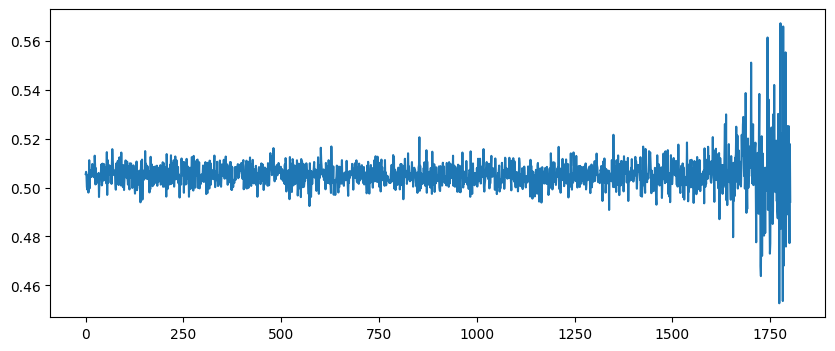

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(out)

In [46]:
label = []
files_dir = glob.glob(os.path.join(test_dir, test_dir_lst[0], 'acc_*.csv'))
for file in files_dir:
    l = []
    df = pd.read_csv(file, sep=',', header=None)

    hsig = df.iloc[:, -2].values
    vsig = df.iloc[:, -1].values

    for signal in [hsig, vsig]:
        xf = fft(signal)
        freqs = fftfreq(len(signal)) * sample_freq

        x = np.abs(xf[1:len(signal)//2])
        freqs = freqs[1:len(signal)//2]

        xf = uniform_filter1d(x, size=5)

        xf = xf[freqs < cutoff_freq]
        l += [np.mean(xf)]
    
    label.append(np.max(l))

label = (np.array(label) - np.min(label)) / (np.max(label) - np.min(label))


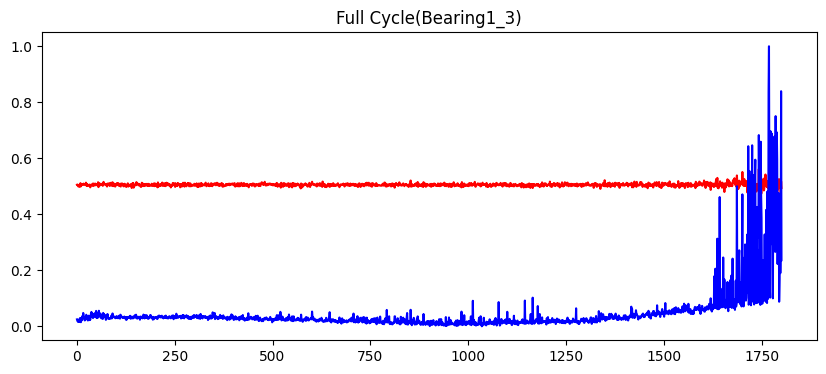

In [47]:
plt.figure(figsize=(10, 4))
plt.title('Full Cycle(Bearing1_3)')
plt.plot(out, c='red')
plt.plot(label, c='blue')

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(label, out)
mae = mean_absolute_error(label, out)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

MSE: 0.22, MAE: 0.46


## RUL

In [3]:
class Cycle_data(Dataset):
    def __init__(self, data_dir, label_dir, data_num=0):
        super(Cycle_data, self).__init__()

        self.files_lst = os.listdir(data_dir)[data_num]
        self.label_dir = glob.glob(os.path.join(label_dir,'*.npy'))[data_num]
        self.files_dir = glob.glob(os.path.join(data_dir, self.files_lst, 'acc_*.csv'))

        self.labels = []
        self.labels += np.load(self.label_dir).tolist()
    
    def __len__(self):
        return len(self.files_dir)

    def __getitem__(self, index):
        
        file_name = self.files_dir[index]
        label = self.labels[index]

        df = pd.read_csv(file_name, sep=',', header=None)
        data = df.iloc[:, -2:].values
        signal = np.transpose(data, (1, 0))

        signal = torch.from_numpy(signal).type(torch.float32)
        label = torch.from_numpy(np.asarray(label)).type(torch.float32)

        return signal, label

In [7]:
train_data = Cycle_data('Learning_set', 'Label')
train_loader_data1 = DataLoader(train_data, batch_size=1, shuffle=False)
model_data1 = CNN((1, 2, 2560), 2, 64).cuda()
epochs = 50
lr = 1e-5
optim_data1 = torch.optim.Adam(model_data1.parameters(), lr=lr)
loss_data1 = nn.SmoothL1Loss()

In [8]:
outs = []
true = []

for data, label in train_loader_data1:
    data = data.cuda()
    label = label.unsqueeze(dim=1).cuda()
    pred = model_data1(data)
    l = loss_data1(pred, label)

    optim_data1.zero_grad()
    l.backward()

    optim_data1.step()
    
    print(f'train_loss: {l}')

    outs.append(pred.detach().cpu().numpy()[0])
    true.append(label.detach().cpu().numpy()[0])

save_dir = 'RUL_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(model_data1.state_dict(), os.path.join(save_dir, 'best_model_data_1.pth'))

train_loss: 0.12566553056240082
train_loss: 0.1105828657746315
train_loss: 0.09547382593154907
train_loss: 0.0854879841208458
train_loss: 0.07804218679666519
train_loss: 0.06662936508655548
train_loss: 0.059290558099746704
train_loss: 0.05075566843152046
train_loss: 0.0411345548927784
train_loss: 0.0383714959025383
train_loss: 0.031237347051501274
train_loss: 0.026115627959370613
train_loss: 0.022425245493650436
train_loss: 0.0183095745742321
train_loss: 0.017029473558068275
train_loss: 0.014909853227436543
train_loss: 0.012147713452577591
train_loss: 0.011494805105030537
train_loss: 0.009110720828175545
train_loss: 0.007635187823325396
train_loss: 0.007384380791336298
train_loss: 0.0037289410829544067
train_loss: 0.004159532953053713
train_loss: 0.003900815499946475
train_loss: 0.001732126111164689
train_loss: 0.002804821589961648
train_loss: 0.0019242590060457587
train_loss: 0.0018677308689802885
train_loss: 0.0014215953415259719
train_loss: 0.0009992093546316028
train_loss: 0.000574

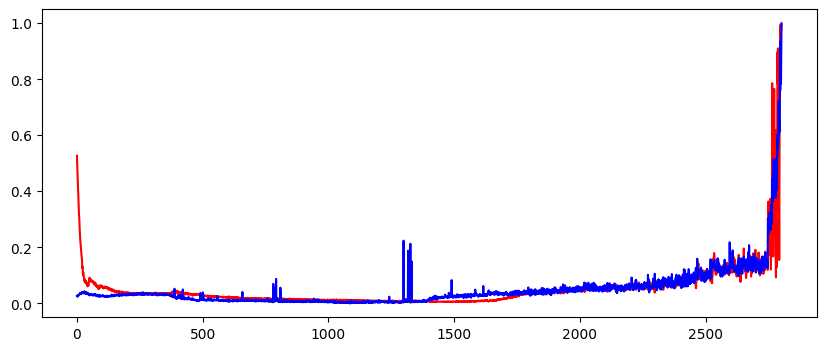

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(outs, c='red')
plt.plot(true, c='blue')

In [12]:
def EU_Dist(mx):
    ab = mx @ mx.T
    aa = np.sum((mx * mx), axis=1)

    eu_dist = aa - 2*ab + aa.T
    eu_dist[eu_dist < 0] = 0
    return eu_dist


In [13]:
def get_adj_from_knn(dist_mx, k):
    N = dist_mx.shape[0]
    adj = np.zeros((N, N))

    for centerx_idx in range(N):
        sorted_idx = np.argsort(dist_mx[centerx_idx])
        nearest_idx = sorted_idx[:k].tolist()

        if centerx_idx not in nearest_idx:
            nearest_idx.append(centerx_idx)

        
        for node_idx in nearest_idx:
            adj[node_idx, centerx_idx] = 1.0
    
    return adj

In [64]:
len(out)

1802